In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import os
import random
import numpy as np
import torch
import torchvision
from torchvision import transforms
from albumentations.pytorch import ToTensorV2
import albumentations as A
from PIL import Image

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.benchmark = True


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [28]:
%%bash
(
if [[ -v "${KAGGLE_KERNEL_RUN_TYPE}" ]]; then
    echo "Kaggle";
    git clone https://github.com/1-1is0/fairness-ai.git;
    cp fairness-ai/train.py train.py;
else
    echo "Local";
fi
)

Local


In [29]:
from typing import Callable, Optional, Any, Tuple


class CustomCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, root: str, train: bool = True, transform: Callable[..., Any] | None = None, target_transform: Callable[..., Any] | None = None, download: bool = False) -> None:
        super().__init__(root, train, transform, target_transform, download)
        all_a, all_b = [], []
        for a, b in zip(self.data, self.targets):
            remove_class_name = "frog"
            remove_index = self.classes.index(remove_class_name)
            if b != remove_index:
                all_a.append(a)
                if b > remove_index:
                    all_b.append(b-1)
                else:
                    all_b.append(b)
        self.data = all_a
        self.targets = all_b
        self.classes.remove(remove_class_name)
        

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)
        img = np.array(img)

        if self.transform is not None:
            img = self.transform(image=img)['image']

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

In [30]:
from multiprocessing import cpu_count

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transform_train = A.Compose([
    A.Resize(32, 32),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.2),
    A.GaussNoise(p=0.5),
    A.Normalize(mean=mean, std=std),
    A.pytorch.ToTensorV2(),
])

transform_test = A.Compose([
    A.Resize(32, 32),
    A.Normalize(mean=mean, std=std),
    A.pytorch.ToTensorV2(),
])

train_dataset = CustomCIFAR10('data', train=True, download=True, transform=transform_train)
test_dataset = CustomCIFAR10('data', train=False, download=True, transform=transform_test)


batch_size = 64
num_workers = cpu_count() - 2
shuffle = True
drop_last = True
pin_memory = True if device.type == 'cuda' else False

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory, drop_last=drop_last)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory, drop_last=drop_last)


Files already downloaded and verified
Files already downloaded and verified


In [31]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

In [32]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
from torch import nn

for p in model.parameters():
    p.requires_grad = False

head = nn.Sequential(
    nn.ReLU(),
    nn.Linear(512, 250),
    nn.BatchNorm1d(250),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(250, len(train_dataset.classes))
)

model.fc = head

In [34]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model/state-ResNet-optimizer-Adam-loss-CrossEntropyLoss.pth Not exist


### BETTER NET STATE ###
[27s] Epoch 1 loss : 2.00158901 acc: 38.4 val: 1.93085612 acc: 44.35%


### BETTER NET STATE ###
[32s] Epoch 2 loss : 1.93920121 acc: 43.88 val: 1.91789921 acc: 44.74%


### BETTER NET STATE ###
[50s] Epoch 3 loss : 1.92781193 acc: 44.74 val: 1.91033578 acc: 45.19%


### BETTER NET STATE ###
[57s] Epoch 4 loss : 1.91866924 acc: 45.47 val: 1.89926120 acc: 46.52%


### BETTER NET STATE ###
[62s] Epoch 5 loss : 1.91259359 acc: 46.11 val: 1.89709511 acc: 46.69%


### BETTER NET STATE ###
[84s] Epoch 6 loss : 1.91119744 acc: 46.07 val: 1.89218202 acc: 47.2%


[172s] Epoch 7 loss : 1.90878266 acc: 46.15 val: 1.89221243 acc: 46.91%


Stopping Saving


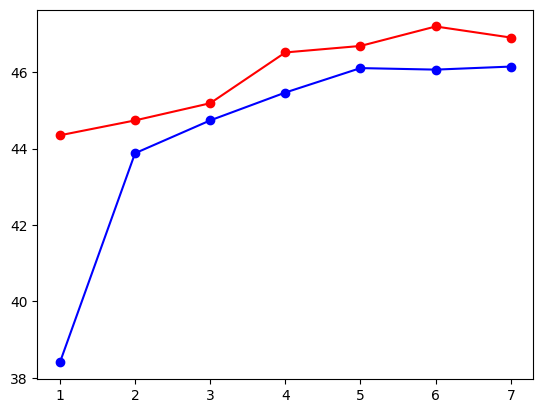

In [36]:
from train import train
from easydict import EasyDict

datasets = EasyDict({
    "train": train_dataset,
    "val": test_dataset,
    "test": test_dataset,
})
data_loaders = EasyDict({
    "train": train_loader,
    "val": test_loader,
    "test": test_loader,
})

state = train(
    net=model,
    criterion=criterion,
    optimizer=optimizer,
    dataset=datasets,
    data_loader=data_loaders,
    device=device,
    epochs=20,
)
